# Block Encoding

High level bloqs for defining bloq encodings and operations on block encodings.

In general, given an $s$-qubit operator $H$ then the $(s+a)$-qubit unitary $U$ is
a $(\alpha, a, \epsilon)$-block encoding of $H$ if it satisfies:

$$
    \lVert H - \alpha (\langle G|_a\otimes I_s U |G\rangle_a \otimes I_s) \rVert
    \le \epsilon,
$$

where $a$ is an ancilla register and $s$ is the system register, $U$ is a unitary sometimes
called a signal oracle and encodes $H$ in its top right corner, $\alpha \ge
\lVert H\rVert$ (where $\lVert \cdot \rVert$ denotes the spectral norm), and
$\epsilon$ is the precision to which the block encoding is prepared. The state
$|G\rangle_a$ is sometimes called the signal state, and its form depends on the
details of the block encoding. 

For LCU based block encodings 
we have
$$
U = \sum_l |l\rangle\langle l| \otimes U_l
$$
and $|G\rangle = \sum_l \sqrt{\frac{\alpha_l}{\alpha}}|0\rangle_a$, which define the
usual SELECT and PREPARE oracles.

Other ways of building block encodings exist so we define the abstract base
class `BlockEncoding` bloq, which expects values for $\alpha$, $\epsilon$,
system and ancilla registers and a bloq which prepares the state $|G\rangle$. 

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `LCUBlockEncoding`
LCU based block encoding using SELECT and PREPARE oracles.

Builds the block encoding via
$$
    B[H] = \mathrm{PREPARE}^\dagger \cdot \mathrm{SELECT} \cdot \mathrm{PREPARE},
$$
where
$$
    \mathrm{PREPARE} |0\rangle_a = \sum_l \sqrt{\frac{w_l}{\lambda}} |l\rangle_a,
$$
and
$$
    \mathrm{SELECT} |l\rangle_a|\psi\rangle_s = |l\rangle_a U_l |\psi\rangle_s.
$$

The ancilla register is at least of size $\log L$.

In our implementations we typically split the ancilla registers into
selection registers (i.e.  the $l$ registers above) and junk registers which
are extra qubits needed by state preparation but not controlled upon during
SELECT.

Here $|G\rangle = \mathrm{PREPARE}|0\rangle$.

#### Parameters
 - `alpha`: The normalization constant upper bounding the spectral norm of the Hamiltonian. Often called lambda.
 - `epsilon`: The precision to which the block encoding is performed. Currently this isn't used: see https://github.com/quantumlib/Qualtran/issues/985
 - `select`: The bloq implementing the `SelectOracle` interface.
 - `prepare`: The bloq implementing the `PrepareOracle` interface. 

#### Registers
 - `selection`: The combined selection register.
 - `junk`: Additional junk registers not prepared upon.
 - `system`: The combined system register. 

#### References
 - [Hamiltonian Simulation by Qubitization](https://quantum-journal.org/papers/q-2019-07-12-163/).     Sec 3.1, page 7 and 8 for high level overview and definitions. A     block encoding is called a standard form encoding there.
 - [The power of block-encoded matrix powers: improved regression techniques via faster Hamiltonian simulation](https://arxiv.org/abs/1804.01973).     Definition 3 page 8.


In [2]:
from qualtran.bloqs.block_encoding import LCUBlockEncoding

### Example Instances

In [3]:
from qualtran.bloqs.hubbard_model import PrepareHubbard, SelectHubbard

# 3x3 hubbard model U/t = 4
dim = 3
select = SelectHubbard(x_dim=dim, y_dim=dim)
U = 4
t = 1
prepare = PrepareHubbard(x_dim=dim, y_dim=dim, t=t, u=U)
N = dim * dim * 2
qlambda = 2 * N * t + (N * U) // 2
black_box_block_bloq = LCUBlockEncoding(
    select=select, prepare=prepare, alpha=qlambda, epsilon=0.0
)

#### Graphical Signature

In [4]:
from qualtran.drawing import show_bloqs
show_bloqs([black_box_block_bloq],
           ['`black_box_block_bloq`'])

### Call Graph

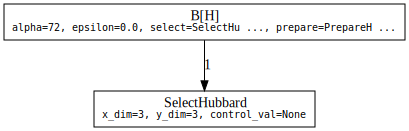

#### Counts totals:
 - `SelectHubbard(x_dim=3, y_dim=3, control_val=None)`: 1

In [5]:
from qualtran.resource_counting.generalizers import ignore_split_join
black_box_block_bloq_g, black_box_block_bloq_sigma = black_box_block_bloq.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(black_box_block_bloq_g)
show_counts_sigma(black_box_block_bloq_sigma)

## `ChebyshevPolynomial`
Block encoding of $T_j[H]$ where $T_j$ is the $j$-th Chebyshev polynomial.

Here H is a Hamiltonian with spectral norm $|H| \le 1$, we assume we have
an $n_L$ qubit ancilla register, and assume that $j > 0$ to avoid block
encoding the identity operator.

Recall:

\begin{align*}
    T_0[H] &= \mathbb{1} \\
    T_1[H] &= H \\
    T_2[H] &= 2 H^2 - \mathbb{1} \\
    T_3[H] &= 4 H^3 - 3 H \\
    &\dots
\end{align*}

See https://github.com/quantumlib/Qualtran/issues/984 for an alternative.

#### Parameters
 - `block_encoding`: Block encoding of a Hamiltonian $H$, $\mathcal{B}[H]$. Assumes the $|G\rangle$ state of the block encoding is the identity operator.
 - `order`: order of Chebychev polynomial. 

#### References
 - [Quantum computing enhanced computational catalysis](https://arxiv.org/abs/2007.14460).     Page 45; Theorem 1.


In [6]:
from qualtran.bloqs.block_encoding import ChebyshevPolynomial

### Example Instances

In [7]:
from qualtran.bloqs.block_encoding import LCUBlockEncoding
from qualtran.bloqs.hubbard_model import PrepareHubbard, SelectHubbard

dim = 3
select = SelectHubbard(x_dim=dim, y_dim=dim)
U = 4
t = 1
prepare = PrepareHubbard(x_dim=dim, y_dim=dim, t=t, u=U)
N = dim * dim * 2
qlambda = 2 * N * t + (N * U) // 2
black_box_block_bloq = LCUBlockEncoding(
    select=select, prepare=prepare, alpha=qlambda, epsilon=0.0
)
chebyshev_poly = ChebyshevPolynomial(black_box_block_bloq, order=3)

#### Graphical Signature

In [8]:
from qualtran.drawing import show_bloqs
show_bloqs([chebyshev_poly.decompose_bloq()],
           ['`chebyshev_poly`'])

### Call Graph

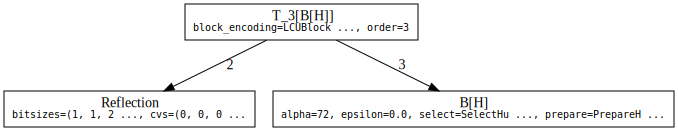

#### Counts totals:
 - `LCUBlockEncoding(alpha=72, epsilon=0.0, select=SelectHubbard(x_dim=3, y_dim=3, control_val=None), prepare=PrepareHubbard(x_dim=3, y_dim=3, t=1, u=4))`: 3
 - `Reflection(bitsizes=(1, 1, 2, 2, 1, 2, 2, 1), cvs=(0, 0, 0, 0, 0, 0, 0, 0))`: 2

In [9]:
from qualtran.resource_counting.generalizers import ignore_split_join
chebyshev_poly_g, chebyshev_poly_sigma = chebyshev_poly.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(chebyshev_poly_g)
show_counts_sigma(chebyshev_poly_sigma)